In [1]:
import os
import time
import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from config import DATASET_PARAMETERS, NETWORKS_PARAMETERS
from parse_dataset import get_dataset
from network import get_network
from utils import Meter, cycle, save_model


# dataset and dataloader
print('Parsing your dataset...')
voice_list, face_list, id_class_num = get_dataset(DATASET_PARAMETERS)
NETWORKS_PARAMETERS['c']['output_channel'] = id_class_num

Parsing your dataset...


In [2]:
print('Preparing the datasets...')
voice_dataset = DATASET_PARAMETERS['voice_dataset'](voice_list,
                               DATASET_PARAMETERS['nframe_range'])
face_dataset = DATASET_PARAMETERS['face_dataset'](face_list)

Preparing the datasets...


In [3]:
print('Preparing the dataloaders...')
collate_fn = DATASET_PARAMETERS['collate_fn'](DATASET_PARAMETERS['nframe_range'])
voice_loader = DataLoader(voice_dataset, shuffle=True, drop_last=True,
                          batch_size=DATASET_PARAMETERS['batch_size'],
                          num_workers=DATASET_PARAMETERS['workers_num'],
                          collate_fn=collate_fn)
face_loader = DataLoader(face_dataset, shuffle=True, drop_last=True,
                         batch_size=DATASET_PARAMETERS['batch_size'],
                         num_workers=DATASET_PARAMETERS['workers_num'])

voice_iterator = iter(cycle(voice_loader))
face_iterator = iter(cycle(face_loader))



Preparing the dataloaders...


In [4]:
# networks, Fe, Fg, Fd (f+d), Fc (f+c)
print('Initializing networks...')
e_net, e_optimizer = get_network('e', NETWORKS_PARAMETERS, train=False)
g_net, g_optimizer = get_network('g', NETWORKS_PARAMETERS, train=True)
f_net, f_optimizer = get_network('f', NETWORKS_PARAMETERS, train=True)
d_net, d_optimizer = get_network('d', NETWORKS_PARAMETERS, train=True)
c_net, c_optimizer = get_network('c', NETWORKS_PARAMETERS, train=True)

# label for real/fake faces
real_label = torch.full((DATASET_PARAMETERS['batch_size'], 1), 1)
fake_label = torch.full((DATASET_PARAMETERS['batch_size'], 1), 0)

# Meters for recording the training status
iteration = Meter('Iter', 'sum', ':5d')
data_time = Meter('Data', 'sum', ':4.2f')
batch_time = Meter('Time', 'sum', ':4.2f')
D_real = Meter('D_real', 'avg', ':3.2f')
D_fake = Meter('D_fake', 'avg', ':3.2f')
C_real = Meter('C_real', 'avg', ':3.2f')
GD_fake = Meter('G_D_fake', 'avg', ':3.2f')
GC_fake = Meter('G_C_fake', 'avg', ':3.2f')



Initializing networks...


In [7]:
print('Training models...')
for it in range(1):#50000
    # data
    start_time = time.time()
    
    voice, voice_label = next(voice_iterator)
    face, face_label = next(face_iterator)
    noise = 0.05*torch.randn(DATASET_PARAMETERS['batch_size'], 64, 1, 1)

    # use GPU or not
    if NETWORKS_PARAMETERS['GPU']: 
        voice, voice_label = voice.cuda(), voice_label.cuda()
        face, face_label = face.cuda(), face_label.cuda()
        real_label, fake_label = real_label.cuda(), fake_label.cuda()
        noise = noise.cuda()
    data_time.update(time.time() - start_time)

    # get embeddings and generated faces
    embeddings = e_net(voice)
    embeddings = F.normalize(embeddings)
    # introduce some permutations
    embeddings = embeddings + noise
    embeddings = F.normalize(embeddings)
    fake = g_net(embeddings)

    # Discriminator
    f_optimizer.zero_grad()
    d_optimizer.zero_grad()
    c_optimizer.zero_grad()
    real_score_out = d_net(f_net(face))
    fake_score_out = d_net(f_net(fake.detach()))
    real_label_out = c_net(f_net(face))
    D_real_loss = F.binary_cross_entropy(torch.sigmoid(real_score_out), real_label.to(torch.float32))
    D_fake_loss = F.binary_cross_entropy(torch.sigmoid(fake_score_out), fake_label.to(torch.float32))
    C_real_loss = F.nll_loss(F.log_softmax(real_label_out, 1), face_label)
    D_real.update(D_real_loss.item())
    D_fake.update(D_fake_loss.item())
    C_real.update(C_real_loss.item())
    (D_real_loss + D_fake_loss + C_real_loss).backward()
    f_optimizer.step()
    d_optimizer.step()
    c_optimizer.step()

    # Generator
    g_optimizer.zero_grad()
    fake_score_out = d_net(f_net(fake))
    fake_label_out = c_net(f_net(fake))
    GD_fake_loss = F.binary_cross_entropy(torch.sigmoid(fake_score_out), real_label.to(torch.float32))
    GC_fake_loss = F.nll_loss(F.log_softmax(fake_label_out, 1), voice_label)
    (GD_fake_loss + GC_fake_loss).backward()
    GD_fake.update(GD_fake_loss.item())
    GC_fake.update(GC_fake_loss.item())
    g_optimizer.step()

    batch_time.update(time.time() - start_time)

    # print status
    if it % 200 == 0:
        print(iteration, data_time, batch_time, 
              D_real, D_fake, C_real, GD_fake, GC_fake)
        data_time.reset()
        batch_time.reset()
        D_real.reset()
        D_fake.reset()
        C_real.reset()
        GD_fake.reset()
        GC_fake.reset()

        # snapshot
        save_model(g_net, NETWORKS_PARAMETERS['g']['model_path'])
    iteration.update(1)



Training models...
Iter:    0, Data:0.76, Time:13.29, D_real:0.69, D_fake:0.69, C_real:6.83, G_D_fake:0.69, G_C_fake:6.83,


In [5]:
import os
import glob
import torch
import torchvision.utils as vutils
import webrtcvad

from mfcc import MFCC
from config import DATASET_PARAMETERS, NETWORKS_PARAMETERS
from network import get_network
from utils import voice2face



In [6]:
# initialization
vad_obj = webrtcvad.Vad(2)
mfc_obj = MFCC(nfilt=64, lowerf=20., upperf=7200., samprate=16000, nfft=1024, wlen=0.025)
e_net, _ = get_network('e', NETWORKS_PARAMETERS, train=False)
g_net, _ = get_network('g', NETWORKS_PARAMETERS, train=False)



In [7]:
# test
voice_path = os.path.join(DATASET_PARAMETERS['test_data'], '*.wav')
voice_list = glob.glob(voice_path)
for filename in voice_list:
    face_image = voice2face(e_net, g_net, filename, vad_obj, mfc_obj,
                            NETWORKS_PARAMETERS['GPU'])
    vutils.save_image(face_image.detach().clamp(-1,1),
                      filename.replace('.wav', '.png'), normalize=True)

In [9]:
from matplotlib.pyplot import imshow
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


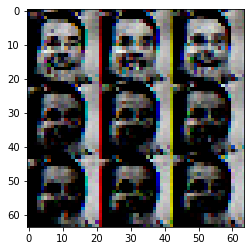

In [20]:
w, h = 20, 20
X = face_image.detach().clamp(-1,1)
X = X[0].reshape(64,64,3)

imshow(X)